In [1]:
import os 
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Move up one directory from the notebook location
notebook_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add that directory to sys.path if not already present
if notebook_root not in sys.path:
    sys.path.insert(0, notebook_root)

from Matrix_methods.Simulate import simulate_parallel
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor

bias of sample_pulse before 60 ps: (-134.13824849159317, -132.0308403428936)


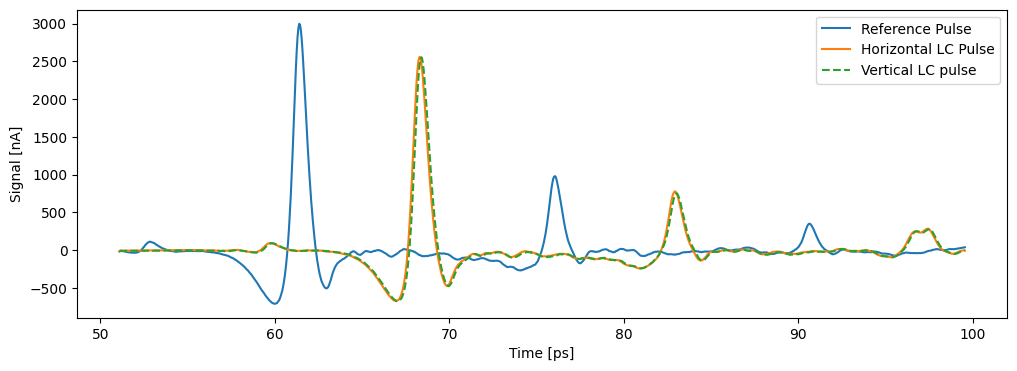

In [2]:
ref_path = 'LC_data/ref_pulse.csv'
ref_df = pd.read_csv(ref_path)
ref_df = ref_df.dropna() # Drop nan values from matlab files
time_axis_ref = ref_df['Time_ps'].to_numpy()
ref_pulse = ref_df['Pulse'].to_numpy()
scaler = max(ref_pulse)
#ref_pulse /= scaler # Scale y axis

hor_pulse_path = 'LC_data/LC_hor_pulse.csv'
hor_pulse_df = pd.read_csv(hor_pulse_path)
hor_pulse_df = hor_pulse_df.dropna()# Drop nan values from matlab files
time_axis_hor = hor_pulse_df['Time_ps'].to_numpy()
hor_pulse = hor_pulse_df['Pulse'].to_numpy()
#hor_pulse /= scaler # Scale y axis


ver_pulse_path = 'LC_data/LC_ver_pulse.csv'
ver_pulse_df = pd.read_csv(ver_pulse_path)
ver_pulse_df = ver_pulse_df.dropna()
time_axis_ver = ver_pulse_df['Time_ps'].to_numpy()
ver_pulse = ver_pulse_df['Pulse'].to_numpy()
#ver_pulse /= scaler # Scale y axis

# Truncate all pulses to equal length
L = len(hor_pulse)
time_axis_ref = time_axis_ref[:L]
hor_pulse = hor_pulse[:L]
ver_pulse = ver_pulse[:L]
ref_pulse = ref_pulse[:L]

# Remove bias from samples
mask = time_axis_ref < 60
bias1 = np.mean(ver_pulse[mask])
bias2 = np.mean(hor_pulse[mask])
midpoint = (bias1 + bias2)/2

ref_pulse -= midpoint
hor_pulse -= bias1
ver_pulse -= bias2
print(f"bias of sample_pulse before 60 ps: {bias1, bias2}")


plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse, label='Reference Pulse')
plt.plot(time_axis_ref, hor_pulse, label='Horizontal LC Pulse')
plt.plot(time_axis_ref, ver_pulse, label='Vertical LC pulse', linestyle='--')
plt.xlabel('Time [ps]')
plt.ylabel('Signal [nA]')
plt.legend()
plt.show()

In [3]:
## Known material params
n_slide = 1.99
k_slide = -1e-5
d_slide = 1040e-6
d_lc = 50*1e-6 #50 microns

In [4]:
## Check resolution of time domain to see what resolution of n we can observe for a given thickness
# Compute time differences between consecutive samples
dt = np.diff(time_axis_ref)

print(f'Time steps: {dt[0] * 1e-12} ps')

# Check for uniform time step (within a small tolerance)
tolerance = 1e-12  # adjust as needed based on your signal's precision
is_uniform = np.all(np.abs(dt - dt[0]) < tolerance)

print("Time steps are uniform:", is_uniform)
if not is_uniform:
    print("Min dt:", np.min(dt))
    print("Max dt:", np.max(dt))
    print("Mean dt:", np.mean(dt))

Time steps: 4.8828125e-14 ps
Time steps are uniform: True


## Find analytical IC's using pulse delay calculations

In [5]:
c = 299792458 

# Use argmin as the sampling is denser in this region.
ref_peak = time_axis_ref[np.argmin(ref_pulse)]

print(f'Peak Time ref: {ref_peak} ps')

hor_peak = time_axis_hor[np.argmin(hor_pulse)]
ver_peak = time_axis_ver[np.argmin(ver_pulse)]

print(f'Peak Time hor: {hor_peak} ps')
print(f'Peak Time ver: {ver_peak} ps')

total_time_delay1 = (hor_peak - ref_peak) * 1e-12
total_time_delay2 = (ver_peak - ref_peak) * 1e-12

print(f'Total Delay hor: {total_time_delay1} s')
print(f'Total Delay ver: {total_time_delay2} s')

time_from_slides = 2 * (d_slide * (n_slide - 1)) / c 
print(f'Delay due to slides: {time_from_slides}')

delay_from_lc1 = total_time_delay1 - time_from_slides
delay_from_lc2 = total_time_delay2 - time_from_slides

print(f'Delay from LC hor: {delay_from_lc1}')
print(f'Delay from LC ver: {delay_from_lc2}')

n_guess1 = ((delay_from_lc1 * c)/ d_lc) + 1
n_guess2 = ((delay_from_lc2 * c)/ d_lc) + 1

print(f'n for LC_1 guess: {n_guess1}')
print(f'n for LC_2 guess: {n_guess2}')

Peak Time ref: 59.9853515625 ps
Peak Time hor: 67.0166015625 ps
Peak Time ver: 66.9677734375 ps
Total Delay hor: 7.03125e-12 s
Total Delay ver: 6.9824218749999995e-12 s
Delay due to slides: 6.868751848320346e-12
Delay from LC hor: 1.6249815167965355e-13
Delay from LC ver: 1.1367002667965311e-13
n for LC_1 guess: 1.9743144062500035
n for LC_2 guess: 1.6815483339843758


### Resolution test

In [6]:
def find_rough_n(ref_peak, sample_peak, sample_thickness):
    delay = sample_peak - ref_peak
    n = ((delay * c) / sample_thickness) + 1
    return n

def find_delay(n_sample, sample_thickness):
    delay = ((n_sample-1)* sample_thickness) / c
    return delay

print(f'Expected delay from 50um with n=1.5: {find_delay(1.5, 50*1e-6)} s')
print(f'Expected delay from 50um with n=1.8: {find_delay(1.8, 50*1e-6)} s')

Expected delay from 50um with n=1.5: 8.3391023799538e-14 s
Expected delay from 50um with n=1.8: 1.3342563807926081e-13 s


## Extractions

In [7]:
# Get delta t for scans and simulations
deltat = np.diff(time_axis_ref)[0]  # Assume equal spacings
print(f'time axis ref: {np.diff(time_axis_ref)[0]} ps')   
deltat = deltat * 1e-12 # Convert to seconds

print(f'{deltat}s')

time axis ref: 0.048828125 ps
4.8828125e-14s


In [8]:
# Convert ref to torch tensor 
ref_pulse_t = torch.tensor(ref_pulse, dtype=torch.float32) 
hor_pulse_t = torch.tensor(hor_pulse, dtype=torch.float32)
ver_pulse_t = torch.tensor(ver_pulse, dtype=torch.float32)

# Initialize params
n_hor_init = 1.8
k_hor_init = 0
n_ver_init = 1.5
k_ver_init = 0


# create mask
optimize_mask = [
    (False, False, False),  # Quartz slide 
    (True, False, False),  #  LC
    (False, False, False)   # Quartz slide 
]

# create init layers
hor_init_guess = [
    ((n_slide + 1j*k_slide), d_slide),      # Quartz slide  
    ((n_hor_init + 1j*k_hor_init), d_lc),   # Horizontal LC 
    ((n_slide + 1j*k_slide), d_slide)       # Quartz slide 
]

### Horizontal LC

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 2 - n ∈ (1.7, 1.9000000000000001)


/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.7] before, using random point [1.740428521248677]
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.7] before, using random point [1.8878352449875266]
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.7] before, using random point [1.734375011250465]
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.7] before, using random point [1.8722021490347018]
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at poin

Bayes params: [((1.99-1e-05j), 0.00104), ((1.7+0j), 4.9999999999999996e-05), ((1.99-1e-05j), 0.00104)]


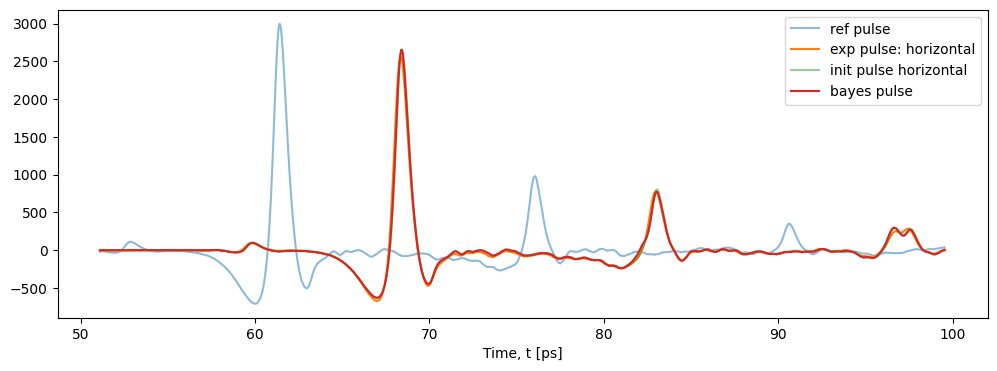

In [9]:
hor_init_pulse = simulate_parallel(ref_pulse_t, hor_init_guess, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

Bayes_model_hor = BayesianLayeredExtractor(ref_pulse_t, hor_pulse_t, deltat=deltat, layers_init=hor_init_guess, optimize_mask=optimize_mask)
bayes_params_hor = Bayes_model_hor.bayesian_optimization(n_calls=50, thickness_delta=0.01e-3)

Bayesian_pulse_hor = simulate_parallel(ref_pulse_t, bayes_params_hor, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(f'Bayes params: {bayes_params_hor}')
plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis_hor, hor_pulse, label='exp pulse: horizontal')
plt.plot(time_axis_ref, hor_init_pulse, label='init pulse horizontal', alpha = 0.5)
plt.plot(time_axis_ref, Bayesian_pulse_hor, label='bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

Fine-tuning 1 parameters for 500 iterations.
Iteration 29, Loss: 6.465816e+01, Layer 0: n=1.9900, k=-0.00001, D=1040.00 µm | Layer 1: n=1.6701, k=0.00000, D=50.00 µm | Layer 2: n=1.9900, k=-0.00001, D=1040.00 µm
Iteration 59, Loss: 6.212811e+01, Layer 0: n=1.9900, k=-0.00001, D=1040.00 µm | Layer 1: n=1.6408, k=0.00000, D=50.00 µm | Layer 2: n=1.9900, k=-0.00001, D=1040.00 µm
Iteration 89, Loss: 5.980742e+01, Layer 0: n=1.9900, k=-0.00001, D=1040.00 µm | Layer 1: n=1.6124, k=0.00000, D=50.00 µm | Layer 2: n=1.9900, k=-0.00001, D=1040.00 µm
Iteration 119, Loss: 5.769840e+01, Layer 0: n=1.9900, k=-0.00001, D=1040.00 µm | Layer 1: n=1.5849, k=0.00000, D=50.00 µm | Layer 2: n=1.9900, k=-0.00001, D=1040.00 µm
Iteration 149, Loss: 5.579882e+01, Layer 0: n=1.9900, k=-0.00001, D=1040.00 µm | Layer 1: n=1.5583, k=0.00000, D=50.00 µm | Layer 2: n=1.9900, k=-0.00001, D=1040.00 µm
Iteration 179, Loss: 5.410351e+01, Layer 0: n=1.9900, k=-0.00001, D=1040.00 µm | Layer 1: n=1.5329, k=0.00000, D=50.00

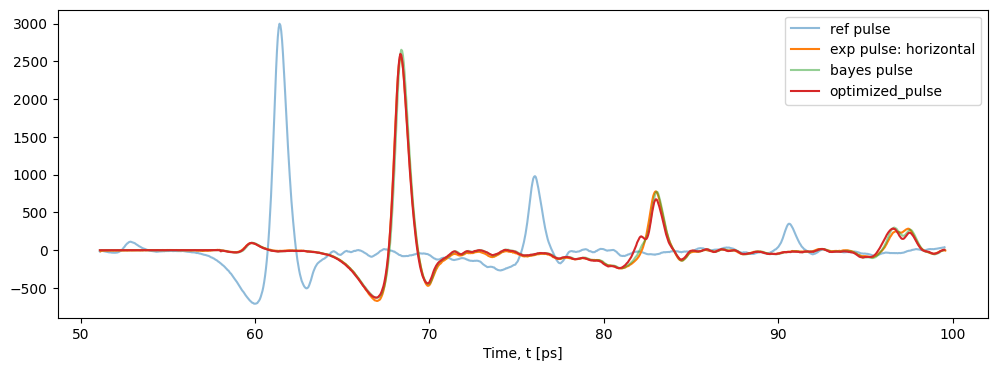

In [10]:
# Initialize gradient optimizer for sample 1
hor_optimizer = LayeredExtractor(
        ref_pulse_t, hor_pulse_t, 
        deltat, 
        bayes_params_hor, 
        optimize_mask
        )

# Execute optimization
hor_layers_opt = hor_optimizer.optimize(num_iterations=500, updates=30)

print(hor_layers_opt)

optimized_pulse_hor = simulate_parallel(ref_pulse_t, hor_layers_opt, deltat, 0)[1].detach().cpu().numpy()[:L]

plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis_hor, hor_pulse, label='exp pulse: horizontal')
plt.plot(time_axis_ref, Bayesian_pulse_hor, label='bayes pulse', alpha = 0.5)
plt.plot(time_axis_ref, optimized_pulse_hor, label='optimized_pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

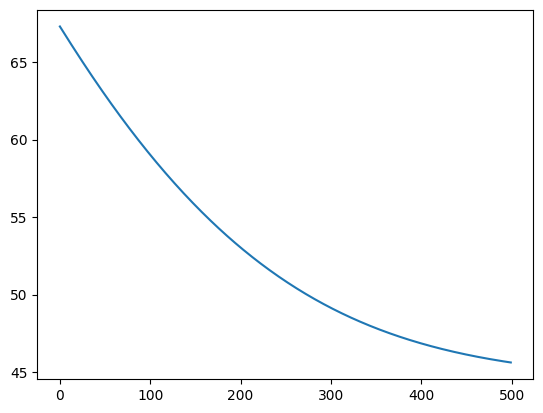

In [11]:
plt.plot(hor_optimizer.loss_history)

### Vertical LC

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 2 - n ∈ (1.4, 1.6)


/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.6] before, using random point [1.440428521248677]
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.6] before, using random point [1.5878352449875266]
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.6] before, using random point [1.4834694104068866]
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.6] before, using random point [1.434375011250465]
  warnings.warn(
/opt/anaconda3/envs/mphys/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at poin

Bayes params: [((1.99-1e-05j), 0.0010400000028312206), ((1.6+0j), 5.0000016926787794e-05), ((1.99-1e-05j), 0.0010400000028312206)]


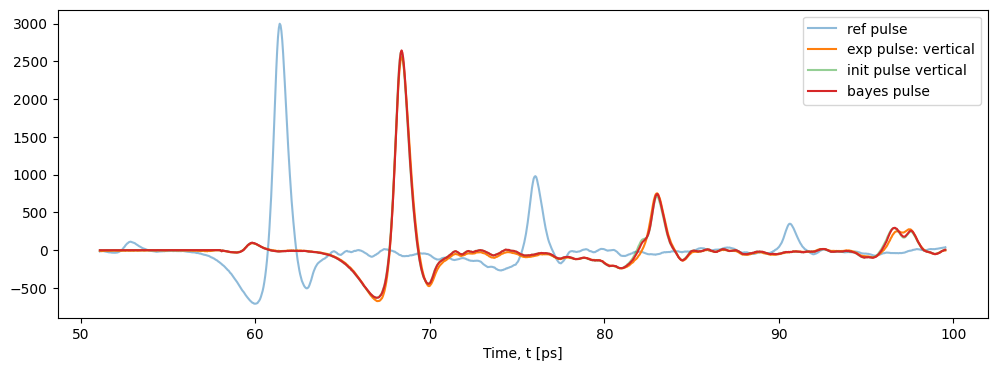

In [12]:
# Change optimization to stop targetting thickness
optimize_mask = [
    (False, False, False),  # Quartz slide 
    (True, False, False),  #  LC
    (False, False, False)   # Quartz slide 
]


# Extract optimized thickness from previous rounds
optimized_lc_d = hor_layers_opt[1][1]
optimized_slide_d = hor_layers_opt[0][1]

ver_init_guess = [
    ((n_slide + 1j*k_slide), optimized_slide_d),      # Quartz slide  
    ((n_ver_init + 1j*k_ver_init), optimized_lc_d),   # Vertical LC 
    ((n_slide + 1j*k_slide), optimized_slide_d)       # Quartz slide 
]

ver_init_pulse = simulate_parallel(ref_pulse_t, ver_init_guess, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

Bayes_model_ver = BayesianLayeredExtractor(ref_pulse_t, ver_pulse_t, deltat=deltat, layers_init=ver_init_guess, optimize_mask=optimize_mask)
bayes_params_ver = Bayes_model_ver.bayesian_optimization(n_calls=50, thickness_delta=0.01e-3)

Bayesian_pulse_ver = simulate_parallel(ref_pulse_t, bayes_params_ver, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(f'Bayes params: {bayes_params_ver}')
plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis_ref, ver_pulse, label='exp pulse: vertical')
plt.plot(time_axis_ref, ver_init_pulse, label='init pulse vertical', alpha = 0.5)
plt.plot(time_axis_ref, Bayesian_pulse_ver, label='bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

Fine-tuning 1 parameters for 300 iterations.
Iteration 29, Loss: 2.305274e+01, Layer 0: n=1.9900, k=-0.00001, D=1040.00 µm | Layer 1: n=1.6294, k=0.00000, D=50.00 µm | Layer 2: n=1.9900, k=-0.00001, D=1040.00 µm
Iteration 59, Loss: 2.194135e+01, Layer 0: n=1.9900, k=-0.00001, D=1040.00 µm | Layer 1: n=1.6558, k=0.00000, D=50.00 µm | Layer 2: n=1.9900, k=-0.00001, D=1040.00 µm
Iteration 89, Loss: 2.134406e+01, Layer 0: n=1.9900, k=-0.00001, D=1040.00 µm | Layer 1: n=1.6766, k=0.00000, D=50.00 µm | Layer 2: n=1.9900, k=-0.00001, D=1040.00 µm
Iteration 119, Loss: 2.109949e+01, Layer 0: n=1.9900, k=-0.00001, D=1040.00 µm | Layer 1: n=1.6911, k=0.00000, D=50.00 µm | Layer 2: n=1.9900, k=-0.00001, D=1040.00 µm
Iteration 149, Loss: 2.102518e+01, Layer 0: n=1.9900, k=-0.00001, D=1040.00 µm | Layer 1: n=1.6997, k=0.00000, D=50.00 µm | Layer 2: n=1.9900, k=-0.00001, D=1040.00 µm
Iteration 179, Loss: 2.100866e+01, Layer 0: n=1.9900, k=-0.00001, D=1040.00 µm | Layer 1: n=1.7041, k=0.00000, D=50.00

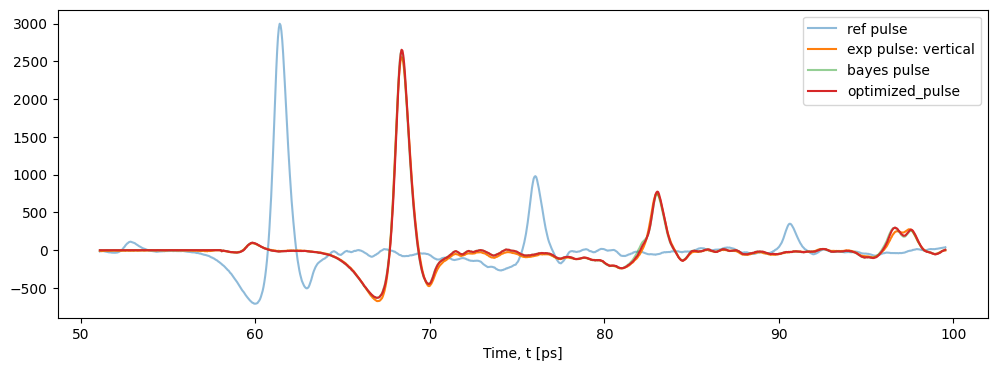

In [13]:
# Initialize gradient optimizer for sample 1
ver_optimizer = LayeredExtractor(
        ref_pulse_t, ver_pulse_t, 
        deltat, 
        bayes_params_ver, 
        optimize_mask
        )

# Execute optimization
ver_layers_opt = ver_optimizer.optimize(num_iterations=300, updates=30)

print(ver_layers_opt)

optimized_pulse_ver = simulate_parallel(ref_pulse_t, ver_layers_opt, deltat, 0)[1].detach().cpu().numpy()[:L]

plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis_ref, ver_pulse, label='exp pulse: vertical')
plt.plot(time_axis_ref, Bayesian_pulse_ver, label='bayes pulse ', alpha = 0.5)
plt.plot(time_axis_ref, optimized_pulse_ver, label='optimized_pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

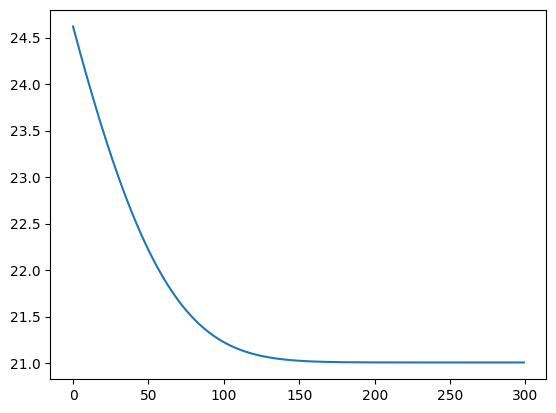

In [14]:
plt.plot(ver_optimizer.loss_history)

In [20]:
print(f'delta n: {1.7068161964416504 - 1.3363608121871948}')

print(f'delta  delta n: {(1.7068161964416504 - 1.3363608121871948) - 0.3375}')

delta n: 0.37045538425445557
delta  delta n: 0.032955384254455544


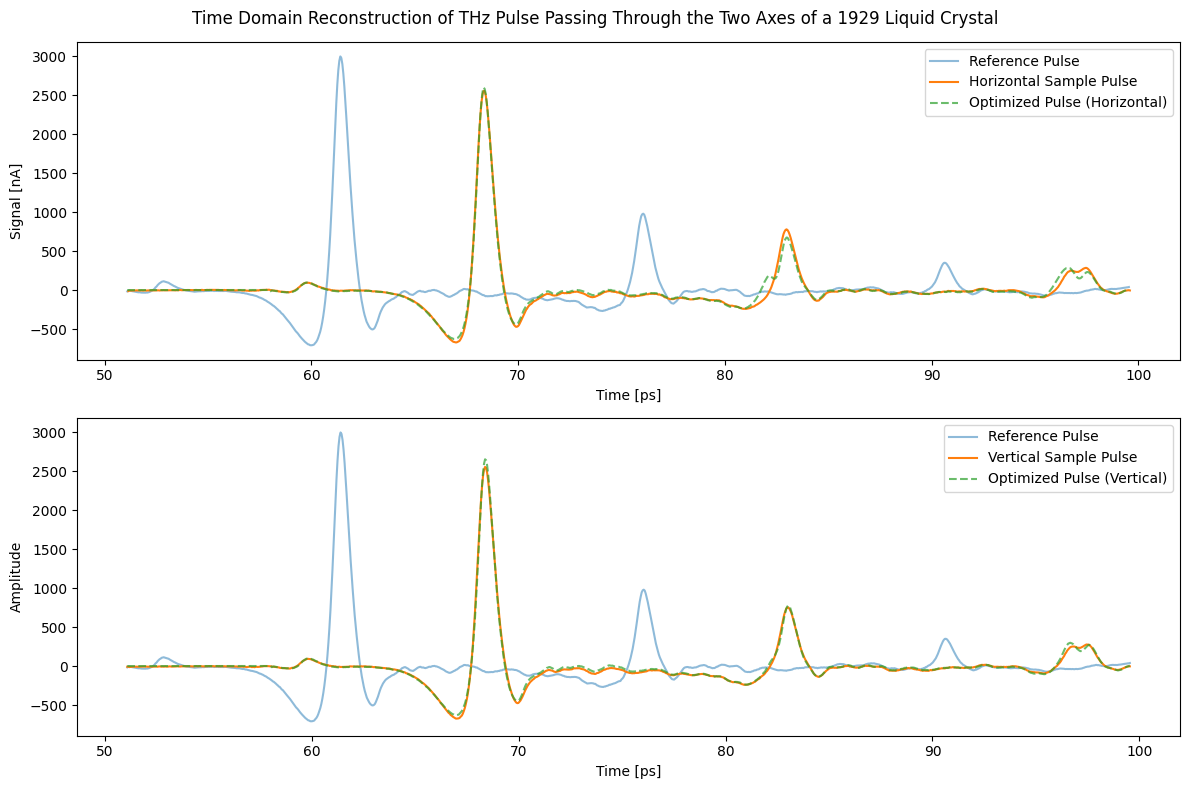

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
fig.suptitle('Time Domain Reconstruction of THz Pulse Passing Through the Two Axes of a 1929 Liquid Crystal')  

# Top plot: Horizontal polarization
axs[0].plot(time_axis_ref, ref_pulse_t, label='Reference Pulse', alpha=0.5)
axs[0].plot(time_axis_hor, hor_pulse, label='Horizontal Sample Pulse')
axs[0].plot(time_axis_ref, optimized_pulse_hor, label='Optimized Pulse (Horizontal)', alpha=0.7, linestyle='--')
axs[0].set_ylabel('Signal [nA]')
axs[0].set_xlabel('Time [ps]')
axs[0].legend()

# Bottom plot: Vertical polarization
axs[1].plot(time_axis_ref, ref_pulse_t, label='Reference Pulse', alpha=0.5)
axs[1].plot(time_axis_ref, ver_pulse, label='Vertical Sample Pulse')
axs[1].plot(time_axis_ref, optimized_pulse_ver, label='Optimized Pulse (Vertical)', alpha=0.7, linestyle='--')
axs[1].set_xlabel('Time [ps]')
axs[1].set_ylabel('Signal [nA]')
axs[1].set_ylabel('Amplitude')
axs[1].legend()

plt.tight_layout() 
plt.show()
